In [ ]:

  import os,sys
  !"{sys.executable}" -m pip install pillow urllib3 matplotlib mpl_interactions ipywidgets ipympl ipycanvas jupyter_contrib_nbextensions
  !"{sys.executable}" -m jupyter nbextension enable --py widgetsnbextension
  !"{sys.executable}" -m pip  install --upgrade OpenVisus
  !"{sys.executable}" -m OpenVisus configure  
  print("WARNING: you probably need to restart Jupyter")

In [3]:
import os,sys,io,random
from PIL import Image
from urllib.request import urlopen
import matplotlib 
import matplotlib.pyplot as plt
from ipywidgets import *
from IPython.display import display
from PIL import Image
import numpy as np


import OpenVisus as ov
print("Current working directory",os.getcwd() )

Starting OpenVisus /home/scrgiorgio/.local/lib/python3.10/site-packages/OpenVisus/__init__.py 3.10.4 (main, Jun 29 2022, 12:14:53) [GCC 11.2.0] sys.version_info(major=3, minor=10, micro=4, releaselevel='final', serial=0) ...
111204456 Kernel:273 125195:140433464156160 setting VISUS_HOME from home directory /home/scrgiorgio/visus
111204456 Kernel:293 125195:140433464156160 setting VISUS_CACHE from VISUS_HOME /home/scrgiorgio/visus/cache
111204457 Kernel:383 125195:140433464156160 VISUS_VERSION
111204457 Kernel:384 125195:140433464156160 VISUS_GIT_REVISION c14934b
111204457 Kernel:385 125195:140433464156160 VISUS_HOME /home/scrgiorgio/visus
111204457 Kernel:386 125195:140433464156160 VISUS_CACHE /home/scrgiorgio/visus/cache
111204457 Kernel:387 125195:140433464156160 VISUS_BINARY_DIR /home/scrgiorgio/.local/lib/python3.10/site-packages/OpenVisus/bin
111204457 Kernel:388 125195:140433464156160 GetCurrentWorkingDirectory() /mnt/c/projects/OpenVisus/Samples/jupyter
111204457 VisusDbPy:77 12

132626552 Dataset:264 125195:140433464156160 
132626552 Dataset:295 125195:140433464156160 Automatically enabling caching for https://s3.us-west-1.wasabisys.com/Pania_2021Q3_in_situ_data/workflow/fly_scan_id_112603.h5/r/idx/1mb/visus.idx?profile=wasabi&cached=1 
 <dataset url="https://s3.us-west-1.wasabisys.com/Pania_2021Q3_in_situ_data/workflow/fly_scan_id_112603.h5/r/idx/1mb/visus.idx?profile=wasabi">
	<access type="multiplex">
		<access type="IdxDiskAccess" chmod="rw" url="/home/scrgiorgio/visus/cache/s3.us-west-1.wasabisys.com/Pania_2021Q3_in_situ_data/workflow/fly_scan_id_112603.h5/r/idx/1mb/visus.idx" />
		<access type="CloudStorageAccess" chmod="r" compression="zip" />
	</access>
</dataset>
132626768 NetService:731 125195:140431836837440 GET connection 0 wait 10 running 200 download 274  -  1 kb/sec) status STATUS_OK url https://s3.us-west-1.wasabisys.com/Pania_2021Q3_in_situ_data/workflow/fly_scan_id_112603.h5/r/idx/1mb/visus.idx?X-Amz-Algorithm=AWS4-HMAC-SHA256&X-Amz-Credentia

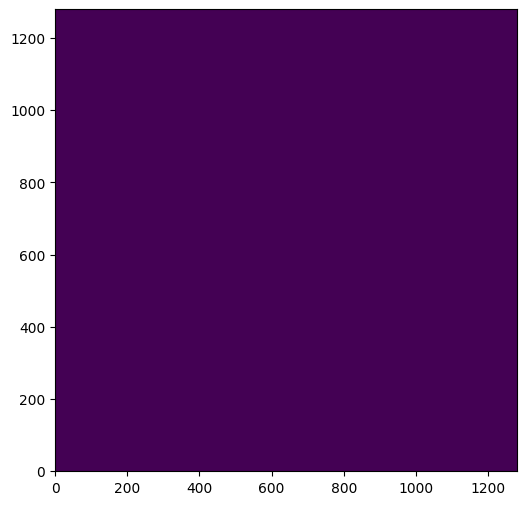

In [10]:
def ReadSlice(db, dir=0, slice=0,quality=-3, time=0,access=None):
	
	# guess quality
 
	# do the read
	W,H,D=db.getLogicSize()
	x=[slice,slice+1] if dir==0 else [0,W]
	y=[slice,slice+1] if dir==1 else [0,H]
	z=[slice,slice+1] if dir==2 else [0,D]
	ret=db.read(x=x, y=y,z=z, quality=quality,time=time,access=None)
 
	# resample to 2d
	width,height=[value for value in ret.shape if value>1]
	return ret.reshape([width,height])


# function to plot the image data with matplotlib
def ShowData(data, cmap=None, plot=None,width = 6):
    ratio=float(data.shape[1])/data.shape[0]
    fig = plt.figure(figsize = (width,width*ratio))
    plot = plt.imshow(data, origin='lower', cmap=cmap)
    return plot

access=

db=ov.LoadDataset("https://s3.us-west-1.wasabisys.com/Pania_2021Q3_in_situ_data/workflow/fly_scan_id_112603.h5/r/idx/1mb/visus.idx?profile=wasabi&cached=1")
access=ov.CreateAccess(ov.StringTree.fromString("""
	<dataset name='wasabi-pania-112603.h5-r' url='hhttps://s3.us-west-1.wasabisys.com/Pania_2021Q3_in_situ_data/workflow/fly_scan_id_112603.h5/r/idx/1mb/visus.idx?profile=wasabi' >
		<!-- note the zz extension -->
		<access type="CloudStorageAccess" filename_template="/Pania_2021Q3_in_situ_data/workflow/fly_scan_id_112603.h5/r/idx/1mb/visus/$(time)/$(field)/$(block:%016x:%04x).bin.zz" />
	</dataset>
"""))
W,H,D=db.getLogicSize()
data=ReadSlice(db, dir=2, slice=D//2,  time=0, quality=-3, access=access) 
ShowData(data)


In [6]:


class Slices:

    # constructor
    def __init__(self, sources):
        self.sources=sources
        self.db=None
        self.access=None
        self.colormapslist =  ['viridis', 'plasma', 'inferno', 'magma', 'cividis','ocean', 'gist_earth', 'terrain', 'gist_stern',
             'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg',
             'gist_rainbow', 'rainbow', 'jet', 'turbo', 'nipy_spectral',
             'gist_ncar']
        self.currentColormap = self.colormapslist[0]
        self.createGui()
        self.setSource(0)
        self.setDirection(2)
        
    # createGui
    def createGui(self):    
        layout_width = '60%'
        style = {'description_width': 'initial'}

        global first_query
        self.image=widgets.Image(value=self.convertToImage(first_query),format='png',layout=Layout(width=layout_width))
        
        self.source = widgets.Dropdown(
            options=[(source['description'],I) for I,source in enumerate(self.sources)], 
            value=0,
            description='Data source:',
            style=style,
            layout=Layout(width='30%'))
        self.source.observe(lambda __unused__ : self.setSource(self.source.value))

        self.colormapsWidget = widgets.Dropdown(
            options=self.colormapslist, 
            value=colormaps[0],
            description='Colormap:',
            style=style,
            layout=Layout(width='30%'))
        self.colormapsWidget.observe(lambda __unused__ : self.refreshSlice())

        self.time  =widgets.IntSlider(
            value=0,
            min=0,
            max=3,
            step=1,
            description="time (0-3)",
            layout=Layout(width='40%'))
        self.time.observe(lambda __unused__ : self.refreshSlice())

        self.direction = widgets.Dropdown(
            options=[('X', 0), ('Y', 1), ('Z', 2)], 
            value=0,
            description='Slice orthogonal to axis:',
            style=style,
            layout=Layout(width='20%'))
        self.direction.observe(lambda __unused__ : self.setDirection(self.direction.value))

        self.slice=widgets.IntSlider(
            value=512,
            min=0,
            max=1024,
            step=1,
            description="slice (0-0)",
            layout=Layout(width=layout_width))
        self.slice.observe(lambda __unused__ : self.refreshSliceDelayed())

        self.resolution =widgets.IntSlider(
            value=-2,min=-5,max=0,step=1,
            description="Resolution (coarse=-5,full=0)",
            style=style,
            layout=Layout(width=layout_width))
        self.resolution.observe(lambda __unused__ : self.refreshSlice())

        self.info = widgets.Label("________________________________________________________")
        
        self.progress = IntProgress(min=0, max=0,layout=Layout(width='70%'))
        self.progress_display = Label("Caching progress" +" "*24)
        
        display(self.image)
        display(HBox([self.source   , self.colormapsWidget]))
        display(HBox([self.direction, self.time  ]))
        display(self.slice)
        display(self.resolution)
        display(self.info)
        display(HBox([self.progress_display, self.progress]))        
        
    # setSource
    def setSource(self,index,cache_data=True): 
        
        # remove previous source
        if self.db:
            self.db.stopCaching()
            del self.db
            self.db=None
            self.access=None
        
        self.db=CachedDataset(PickSource(index))
        self.access=self.db.createAccess()
        
        if cache_data:
            self.db.startCaching() 
            self.db.setProgress(self.progress,self.progress_display)
        
        self.refreshSlice()   
        
    # setDirection
    def setDirection(self,value):
        self.direction.value=value
        self.slice.max = self.db.getLogicBox()[1][value]-1        
        self.slice.value = self.slice.max//2
        self.slice.description = "slice (0-{})".format(self.slice.max)   
        self.refreshSlice()

    # refreshSlice
    def refreshSlice(self):
        # euristic to map resolution to slice/quality
        self.currentColormap = self.colormapsWidget.value
        resolution = self.resolution.value
        quality = resolution*3
        size_denominator = int(2**(resolution*-1))
        slice = self.slice.value //size_denominator
        slice = slice *size_denominator

        self.info.value = "Time={}, Direction={}, Slice={}  Resolution={} {} , Source={}".format(
            self.time.value,
            ['X', 'Y', 'Z'][self.direction.value],
            slice,
            resolution,
            ["(coarsest)","(coarser) ","(coarse)  ","(medium)  ","(fine)    "," (full)   "] [5+resolution],
            self.source.options[self.source.value][0]) 
    
        data = self.db.readSlice(dir=self.direction.value, slice=slice,quality=quality, time=self.time.value, access=self.access)
        if data is None:
            return
        
        self.image.value = self.convertToImage(data)

    # refreshSlice
    refresh_count = 0
    refresh_frequency = 10
    def refreshSliceDelayed(self):
        self.refresh_count = self.refresh_count+1
        if self.refresh_count == self.refresh_frequency:
            self.refresh_count = 0
            self.refreshSlice()
        else:
            return
        
        
    # convertToImage
    min=max=None
    def convertToImage(self, data):
        buffer = io.BytesIO()
        if self.min == None or self.min > np.amin(data):
            self.min = np.amin(data)
        if self.max == None or self.max < np.amax(data):
            self.max = np.amax(data)
        data = (data - self.min)/  (self.max-self.min)
        image = np.uint8(matplotlib.cm.get_cmap(self.currentColormap, 255)(data)*255)
        Image.fromarray(image).save(buffer, format='png')
        return buffer.getvalue()        

        
slices=Slices(sources,colormaps)

"Interactive slicing of dataset retrieved from the cloud and cached locally in: "+local_cache

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\x10\x00\x00\x02\x00\x08\x06\x00\x00\x00\xd3\xd6U…

IntSlider(value=512, description='slice (0-0)', layout=Layout(width='60%'), max=1024)

IntSlider(value=-2, description='Resolution (coarse=-5,full=0)', layout=Layout(width='60%'), max=0, min=-5, st…

Label(value='________________________________________________________')

'Interactive slicing of dataset retrieved from the cloud and cached locally in: ./visus-cache/foam/visus.idx'

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed